In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# BaseLayer class
class BaseLayer:
    def __init__(self):
        self.input_shape = None
        self.output_shape = None
        self.layer_type = "Base"
        self.params = {}  # Renamed to params for consistency
        self.optimizer = None  # This will be set by the model
        self.initializer = 'xavier'  # Default initializer

    def set_initializer(self, initializer):
        self.initializer = initializer

    def build(self, input_shape):
        self.input_shape = input_shape
        self._assert_input_shape(input_shape)
        if self.optimizer:
            self.optimizer.init_params(self)

    def forward(self, inputs):
        raise NotImplementedError("Forward pass not implemented")

    def backward(self, grads):
        raise NotImplementedError("Backward pass not implemented")

    def update(self):
        pass

    def l2_regularization(self, l2_lambda):
        if "W" in self.params:
            return l2_lambda * np.sum(self.params["W"] ** 2) / 2
        return 0.0

    def get_num_parameters(self):
        return 0

    def summary(self):
        raise NotImplementedError("Summary method not implemented")

    def _assert_input_shape(self, input_shape):
        if len(self.input_shape[1:]) != len(input_shape[1:]):
            raise ValueError("Dimensions mismatch.")
        for expected_dim, actual_dim in zip(self.input_shape[1:], input_shape[1:]):
            if expected_dim is not None and expected_dim != actual_dim:
                raise ValueError(f"Expected {expected_dim}, but got {actual_dim}")

In [ ]:
# @title Optimizers
class Optimizer:
    def __init__(self, use_agc=False, clip_factor=0.1):
        self.use_agc = use_agc
        self.clip_factor = clip_factor

    def adaptive_gradient_clipping(self, layer, grads):
        for key in layer.params.keys():
            grad_norm = np.linalg.norm(grads["d" + key])
            param_norm = np.linalg.norm(layer.params[key])
            max_norm = self.clip_factor * (param_norm + 1e-8)

            # Compute the clipping factor
            clipping_factor = min(1, max_norm / (grad_norm + 1e-8))

            # Apply clipping to the gradient
            grads["d" + key] = clipping_factor * grads["d" + key]

    def init_params(self, layer):
        pass

    def update(self, layer, grads, lr):
        if self.use_agc:
            self.adaptive_gradient_clipping(layer, grads)


class SGD(Optimizer):
    def update(self, layer, grads, lr):
        super().update(layer, grads, lr)
        for key in layer.params.keys():
            layer.params[key] -= lr * grads["d" + key]

class SGDmom(Optimizer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.momentum = 0.9

    def init_params(self, layer):
        layer.v = {}
        for key in layer.params.keys():
            layer.v["d" + key] = np.zeros_like(layer.params[key])

    def update(self, layer, grads, lr):
        super().update(layer, grads, lr)
        for key in layer.params.keys():
            layer.v["d" + key] = self.momentum * layer.v["d" + key] + (1 - self.momentum) * grads["d" + key]
            layer.params[key] -= lr * layer.v["d" + key]

class RMSprop(Optimizer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.decay = 0.9
        self.epsilon = 1e-8

    def init_params(self, layer):
        layer.s = {}
        for key in layer.params.keys():
            layer.s["d" + key] = np.zeros_like(layer.params[key])

    def update(self, layer, grads, lr):
        super().update(layer, grads, lr)
        for key in layer.params.keys():
            layer.s["d" + key] = self.decay * layer.s["d" + key] + (1 - self.decay) * grads["d" + key]**2
            layer.params[key] -= lr * grads["d" + key] / (np.sqrt(layer.s["d" + key]) + self.epsilon)

class AdaGrad(Optimizer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = 1e-8

    def init_params(self, layer):
        layer.h = {}
        for key in layer.params.keys():
            layer.h["d" + key] = np.zeros_like(layer.params[key])

    def update(self, layer, grads, lr):
        super().update(layer, grads, lr)
        for key in layer.params.keys():
            layer.h["d" + key] += grads["d" + key] ** 2
            layer.params[key] -= lr * grads["d" + key] / (np.sqrt(layer.h["d" + key]) + self.epsilon)

class AdaDelta(Optimizer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.decay = 0.9
        self.epsilon = 1e-8

    def init_params(self, layer):
        layer.h = {}
        layer.delta = {}
        for key in layer.params.keys():
            layer.h["d" + key] = np.zeros_like(layer.params[key])
            layer.delta["d" + key] = np.zeros_like(layer.params[key])

    def update(self, layer, grads, lr):
        super().update(layer, grads, lr)
        for key in layer.params.keys():
            layer.h["d" + key] = self.decay * layer.h["d" + key] + (1 - self.decay) * grads["d" + key]**2
            dx = -(np.sqrt(layer.delta["d" + key] + self.epsilon) / np.sqrt(layer.h["d" + key] + self.epsilon)) * grads["d" + key]
            layer.params[key] += dx
            layer.delta["d" + key] = self.decay * layer.delta["d" + key] + (1 - self.decay) * dx**2

class Adam(Optimizer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def init_params(self, layer):
        layer.v = {}
        layer.s = {}
        layer.t = 0  # Initialize time step for each layer
        for key in layer.params.keys():
            layer.v["d" + key] = np.zeros_like(layer.params[key])
            layer.s["d" + key] = np.zeros_like(layer.params[key])

    def update(self, layer, grads, lr):
        super().update(layer, grads, lr)
        layer.t += 1  # Increment layer-specific time step
        v_corr = {}
        s_corr = {}
        for key in layer.params.keys():
            layer.v["d" + key] = self.beta1 * layer.v["d" + key] + (1 - self.beta1) * grads["d" + key]
            v_corr["d" + key] = layer.v["d" + key] / (1 - self.beta1 ** layer.t)

            layer.s["d" + key] = self.beta2 * layer.s["d" + key] + (1 - self.beta2) * np.square(grads["d" + key])
            s_corr["d" + key] = layer.s["d" + key] / (1 - self.beta2 ** layer.t)

            layer.params[key] -= lr * v_corr["d" + key] / (np.sqrt(s_corr["d" + key]) + self.epsilon)

class AdamW(Adam):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        super(AdamW, self).__init__()
        self.weight_decay = 0.01

    def update(self, layer, grads, lr):
        super().update(layer, grads, lr)
        layer.t += 1  # Increment layer-specific time step
        v_corr = {}
        s_corr = {}
        for key in layer.params.keys():
            layer.v["d" + key] = self.beta1 * layer.v["d" + key] + (1 - self.beta1) * grads["d" + key]
            v_corr["d" + key] = layer.v["d" + key] / (1 - self.beta1 ** layer.t)

            layer.s["d" + key] = self.beta2 * layer.s["d" + key] + (1 - self.beta2) * np.square(grads["d" + key])
            s_corr["d" + key] = layer.s["d" + key] / (1 - self.beta2 ** layer.t)

            layer.params[key] -= lr * v_corr["d" + key] / (np.sqrt(s_corr["d" + key]) + self.epsilon)

            # AdamW adds weight decay directly to the parameter update step
            if key == 'W':  # Apply weight decay only to weights, not biases
                layer.params[key] -= lr * self.weight_decay * layer.params[key]


class NAG(Optimizer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.momentum = 0.9

    def init_params(self, layer):
        layer.v = {}
        for key in layer.params.keys():
            layer.v["d" + key] = np.zeros_like(layer.params[key])

    def update(self, layer, grads, lr):
        super().update(layer, grads, lr)
        for key in layer.params.keys():
            old_v = layer.v["d" + key]
            layer.v["d" + key] = self.momentum * layer.v["d" + key] - lr * grads["d" + key]
            layer.params[key] += -self.momentum * old_v + (1 + self.momentum) * layer.v["d" + key]

class AMSGrad(Optimizer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def init_params(self, layer):
        layer.v = {}
        layer.s = {}
        layer.hat_s = {}
        layer.t = 0  # Initialize time step for each layer
        for key in layer.params.keys():
            layer.v["d" + key] = np.zeros_like(layer.params[key])
            layer.s["d" + key] = np.zeros_like(layer.params[key])
            layer.hat_s["d" + key] = np.zeros_like(layer.params[key])

    def update(self, layer, grads, lr):
        super().update(layer, grads, lr)
        layer.t += 1  # Increment layer-specific time step
        v_corr = {}
        for key in layer.params.keys():
            layer.v["d" + key] = self.beta1 * layer.v["d" + key] + (1 - self.beta1) * grads["d" + key]
            v_corr["d" + key] = layer.v["d" + key] / (1 - self.beta1 ** layer.t)

            layer.s["d" + key] = self.beta2 * layer.s["d" + key] + (1 - self.beta2) * np.square(grads["d" + key])
            layer.hat_s["d" + key] = np.maximum(layer.hat_s["d" + key], layer.s["d" + key])

            layer.params[key] -= lr * v_corr["d" + key] / (np.sqrt(layer.hat_s["d" + key]) + self.epsilon)


class Yogi(Optimizer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-3

    def init_params(self, layer):
        layer.v = {}
        layer.s = {}
        layer.t = 0  # Initialize time step for each layer
        for key in layer.params.keys():
            layer.v["d" + key] = np.zeros_like(layer.params[key])
            layer.s["d" + key] = np.zeros_like(layer.params[key])

    def update(self, layer, grads, lr):
        super().update(layer, grads, lr)
        layer.t += 1  # Increment layer-specific time step
        v_corr = {}
        for key in layer.params.keys():
            layer.v["d" + key] = self.beta1 * layer.v["d" + key] + (1 - self.beta1) * grads["d" + key]
            v_corr["d" + key] = layer.v["d" + key] / (1 - self.beta1 ** layer.t)

            sign = np.sign(layer.s["d" + key] - grads["d" + key] ** 2)
            layer.s["d" + key] = self.beta2 * layer.s["d" + key] + (1 - self.beta2) * sign * grads["d" + key] ** 2

            # Ensuring the terms inside the square root are non-negative
            layer.s["d" + key] = np.abs(layer.s["d" + key])

            layer.params[key] -= lr * v_corr["d" + key] / (np.sqrt(layer.s["d" + key]) + self.epsilon)


class AdaFactor(Optimizer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.epsilon1 = 1e-30
        self.epsilon2 = 1e-3
        self.decay = 0.999

    def init_params(self, layer):
        layer.v_row = {}
        layer.v_col = {}
        layer.t = 0  # Initialize time step for each layer
        for key in layer.params.keys():
            if len(layer.params[key].shape) == 2:  # For 2D parameters (e.g., weights)
                layer.v_row["d" + key] = np.zeros(layer.params[key].shape[0])
                layer.v_col["d" + key] = np.zeros(layer.params[key].shape[1])
            else:  # For 1D parameters (e.g., biases)
                layer.v_row["d" + key] = np.zeros_like(layer.params[key])
                layer.v_col["d" + key] = None  # Not applicable for 1D parameters

    def update(self, layer, grads, lr):
        super().update(layer, grads, lr)
        layer.t += 1  # Increment layer-specific time step
        for key in layer.params.keys():
            grad = grads["d" + key]
            if len(grad.shape) == 2:  # For 2D gradients (e.g., weight gradients)
                layer.v_row["d" + key] = self.decay * layer.v_row["d" + key] + (1 - self.decay) * np.sum(grad ** 2, axis=1)
                layer.v_col["d" + key] = self.decay * layer.v_col["d" + key] + (1 - self.decay) * np.sum(grad ** 2, axis=0)

                v_row = np.sqrt(layer.v_row["d" + key] + self.epsilon1).reshape(-1, 1)
                v_col = np.sqrt(layer.v_col["d" + key] + self.epsilon1).reshape(1, -1)
                factor_v = grad / (v_row * v_col + self.epsilon2)
            else:  # For 1D gradients (e.g., bias gradients)
                v_row = np.sqrt(layer.v_row["d" + key] + self.epsilon1)
                factor_v = grad / (v_row + self.epsilon2)

            layer.params[key] -= lr * factor_v

| Optimizer     | Reference              | When should I use this?                                       | Research Paper Link                                     |
|---------------|------------------------|-----------------------------------------------------|---------------------------------------------------------|
| SGD           | `SGD()`                | Classic optimizer for vanilla gradient descent.    | [SGD Paper](http://www.cs.toronto.edu/~fritz/absps/momentum.pdf) |
| SGDmom        | `SGDmom()`             | Gradient descent with momentum for faster convergence. | [SGDmom Paper](http://www.cs.toronto.edu/~fritz/absps/momentum.pdf) |
| RMSprop       | `RMSprop()`            | Effective for non-stationary and noisy datasets.   | [RMSprop Paper](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) |
| AdaGrad       | `AdaGrad()`            | Suitable for sparse data and convex optimization.  | [AdaGrad Paper](https://jmlr.org/papers/v12/duchi11a.html) |
| AdaDelta      | `AdaDelta()`           | Robust optimizer with minimal hyperparameter tuning. | [AdaDelta Paper](https://arxiv.org/abs/1212.5701)   |
| Adam          | `Adam()`               | Versatile optimizer suitable for various tasks.    | [Adam Paper](https://arxiv.org/abs/1412.6980)        |
| AdamW         | `AdamW()`              | Adam with weight decay, useful for regularization. | [AdamW Paper](https://arxiv.org/abs/1711.05101)      |
| NAG           | `NAG()`                | Enhanced gradient descent with Nesterov momentum.  | [NAG Paper](https://www.cs.toronto.edu/~fritz/absps/momentum.pdf) |
| AMSGrad  WIP     | `AMSGrad()`            | Variant of Adam with a stable update rule.         | [AMSGrad Paper](https://openreview.net/forum?id=ryQu7f-RZ) |
| Yogi          | `Yogi()`               | Adam variant with different learning rate behavior. | [Yogi Paper](https://proceedings.neurips.cc/paper_files/paper/2018/file/90365351ccc7437a1309dc64e4db32a3-Paper.pdf)|
| AdaFactor WIP    | `AdaFactor()`          | Adaptive factorization for versatile optimization.  | [AdaFactor Paper](https://arxiv.org/abs/1804.04235)  |


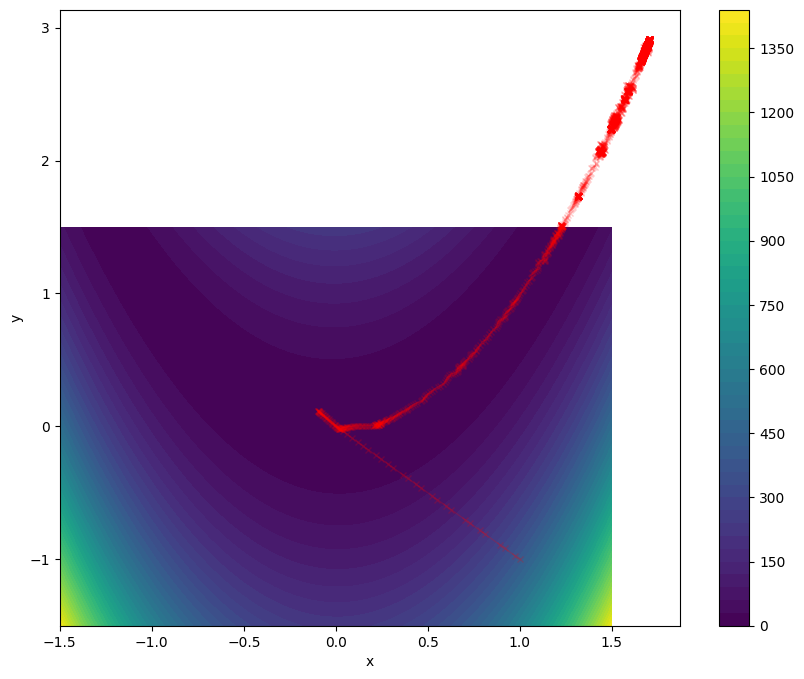

In [ ]:
# Define the Rosenbrock function and its gradients
def rosenbrock(x, y, a=2, b=100):
    return (a - x)**2 + b*(y - x**2)**2

def rosenbrock_grad(x, y, a=2, b=100):
    dx = -2*(a - x) - 4*b*x*(y - x**2)
    dy = 2*b*(y - x**2)
    return {"dx": dx, "dy": dy}

class RosenbrockLayer(BaseLayer):
    def __init__(self):
        super().__init__()
        self.params = {"x": np.array([1.0]), "y": np.array([-1.0])}

layer = RosenbrockLayer()
optimizer = Yogi(use_agc=True)
optimizer.init_params(layer)

# Optimization loop
lr = 0.001
iterations = 3000
path = []

for i in range(iterations):
    x, y = layer.params["x"], layer.params["y"]
    path.append((x[0], y[0]))
    grads = rosenbrock_grad(x, y)
    optimizer.update(layer, grads, lr)

# Extract path for plotting
path = np.array(path)

x_vals = np.linspace(-1.5, 1.5, 400)
y_vals = np.linspace(-1.5, 1.5, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rosenbrock(X, Y)

plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, 50, cmap='viridis')
plt.colorbar()
plt.plot(path[:, 0], path[:, 1], c='red', label='Optimizer Path', marker='x', markersize=4, linewidth=1, alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# @title Conv2d Layer with looping
class Conv2D(BaseLayer):
    def __init__(self, filters, kernel_size, stride=1, padding=0, activation='relu', initializer='xavier'):
        super().__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.initializer = initializer  # New initializer parameter
        self.layer_type = "Conv2D"
        self.params = {"W": None, "b": None}

    def build(self, input_shape):
        super().build(input_shape)
        C = input_shape[-1]
        KH, KW = self.kernel_size
        if self.padding == 'same':
            self.padding = ((input_shape[1] - 1) * self.stride + KH - input_shape[1]) // 2
        self.output_shape = self._calculate_output_shape(input_shape)

        # Choose initializer
        if self.initializer == "xavier":
            self.params["W"] = np.random.randn(KH, KW, C, self.filters) * np.sqrt(2.0 / (KH * KW * C))
        elif self.initializer == "he":
            self.params["W"] = np.random.randn(KH, KW, C, self.filters) * np.sqrt(2.0 / (KH * KW * C))
        elif self.initializer == "random":
            self.params["W"] = np.random.randn(KH, KW, C, self.filters)
        else:
            raise ValueError("Invalid initializer. Choose from 'xavier', 'he', or 'random'.")

        self.params["b"] = np.zeros((1, 1, 1, self.filters))

    def _calculate_output_shape(self, input_shape):
        N, H, W, _ = input_shape
        KH, KW = self.kernel_size
        OH, OW = (H + 2 * self.padding - KH) // self.stride + 1, (W + 2 * self.padding - KW) // self.stride + 1
        return (N, OH, OW, self.filters)

    def forward(self, inputs, training=True):
        self._assert_input_shape(inputs.shape)
        self.inputs = np.pad(inputs, ((0,0), (self.padding, self.padding), (self.padding, self.padding), (0,0)), 'constant')
        N, H, W, C = self.inputs.shape
        KH, KW = self.kernel_size
        _, OH, OW, _ = self.output_shape

        outputs = np.zeros((N, OH, OW, self.filters))
        for n in range(N):
            for h in range(0, H-KH+1, self.stride):
                for w in range(0, W-KW+1, self.stride):
                    for f in range(self.filters):
                        outputs[n, h//self.stride, w//self.stride, f] = np.sum(
                            self.inputs[n, h:h+KH, w:w+KW, :] * self.params["W"][:, :, :, f]
                        ) + self.params["b"][0, 0, 0, f]

        if self.activation == 'relu':
            outputs = np.maximum(0, outputs)

        self.outputs = outputs
        return outputs

    def backward(self, grads, learning_rate):
        dparams = {"dW": np.zeros_like(self.params["W"]), "db": np.zeros_like(self.params["b"])}
        if self.activation == 'relu':
            grads[self.outputs <= 0] = 0

        N, H, W, C = self.inputs.shape
        KH, KW = self.kernel_size
        _, OH, OW, _ = self.output_shape

        dinputs = np.zeros((N, H, W, C))
        for n in range(N):
            for h in range(0, H-KH+1, self.stride):
                for w in range(0, W-KW+1, self.stride):
                    for f in range(self.filters):
                        dparams["dW"][:, :, :, f] += self.inputs[n, h:h+KH, w:w+KW, :] * grads[n, h//self.stride, w//self.stride, f]
                        dparams["db"][0, 0, 0, f] += grads[n, h//self.stride, w//self.stride, f]
                        dinputs[n, h:h+KH, w:w+KW, :] += self.params["W"][:, :, :, f] * grads[n, h//self.stride, w//self.stride, f]

        self.optimizer.update(self, dparams, learning_rate)

        if self.padding > 0:
            dinputs = dinputs[:, self.padding:-self.padding, self.padding:-self.padding, :]
        return dinputs

    def get_num_parameters(self):
        return np.prod(self.params["W"].shape) + np.prod(self.params["b"].shape)

    def summary(self):
        return ["Convolution2D", self.output_shape[1:], self.get_num_parameters(), "relu" if self.activation == "relu" else self.activation]

I definitely didn't steal this from MATLAB (I did)

## im2col Function

### Input and Output

- **Input**: $ \text{inputs} \in \mathbb{R}^{N \times H \times W \times C} $  
  $ N $ is the batch size, $ H $ is the height, $ W $ is the width, and $ C $ is the number of channels.

- **Output**: $ \text{col matrix} \in \mathbb{R}^{(KH \times KW \times C) \times (N \times OH \times OW)} $

### Operations

1. **Padding**: Adds zero-padding to the input matrix.  
   $$
   \text{inputs padded} \in \mathbb{R}^{N \times (H + 2 \times \text{padding}) \times (W + 2 \times \text{padding}) \times C}
   $$

2. **Initialization**: Initialize an empty $ \text{col matrix} $.

3. **Iteration and Reshaping**: Loop through the padded input to create patches and fill $ \text{col matrix} $.  
   For each patch,  
   $$
   \text{patch} \in \mathbb{R}^{N \times KH \times KW \times C}
   $$
   The patch is reshaped and transposed to $ \mathbb{R}^{(KH \times KW \times C) \times N} $ before being placed into $ \text{col matrix} $.

## col2im Function

### Input and Output

- **Input**: $ \text{col matrix} \in \mathbb{R}^{(KH \times KW \times C) \times (N \times OH \times OW)} $
  
- **Output**: $ \text{dinputs} \in \mathbb{R}^{N \times H \times W \times C} $

### Operations

1. **Initialization**: Create $ \text{dinputs padded} $ with zero values and shape $ N \times (H + 2 \times \text{padding}) \times (W + 2 \times \text{padding}) \times C $.

2. **Iteration and Aggregation**: Loop through $ \text{col matrix} $ to distribute the values back into their respective locations in $ \text{dinputs padded} $.  
   For each column patch in $ \text{col matrix} $,  
   $$
   \text{col patch} \in \mathbb{R}^{KH \times KW \times C \times N}
   $$
   This patch is reshaped and added to the corresponding location in $ \text{dinputs padded} $.

3. **Remove Padding**: If padding exists, it's removed to get $ \text{dinputs} $.


In [ ]:
def im2col(inputs, kernel_size, stride, padding):
    N, H, W, C = inputs.shape
    KH, KW = kernel_size
    inputs_padded = np.pad(inputs, ((0, 0), (padding, padding), (padding, padding), (0, 0)), 'constant')
    N, H_padded, W_padded, C = inputs_padded.shape
    OH = (H_padded - KH) // stride + 1
    OW = (W_padded - KW) // stride + 1
    col_matrix = np.zeros((KH * KW * C, N * OH * OW))
    col_idx = 0
    for i in range(0, H_padded - KH + 1, stride):
        for j in range(0, W_padded - KW + 1, stride):
            if col_idx + N > col_matrix.shape[1]:
                break
            patch = inputs_padded[:, i:i+KH, j:j+KW, :]
            col_matrix[:, col_idx:col_idx + N] = patch.reshape(N, -1).T
            col_idx += N
    return col_matrix

def col2im(col_matrix, input_shape, kernel_size, stride, padding):
    N, H, W, C = input_shape
    KH, KW = kernel_size
    OH = (H + 2 * padding - KH) // stride + 1
    OW = (W + 2 * padding - KW) // stride + 1
    dinputs_padded = np.zeros((N, H + 2 * padding, W + 2 * padding, C))
    col_idx = 0
    max_col_idx = col_matrix.shape[1] - N  # Adjust the maximum col_idx by subtracting N
    for i in range(0, H + 2 * padding - KH + 1, stride):
        for j in range(0, W + 2 * padding - KW + 1, stride):
            if col_idx > max_col_idx:
                break
            col_patch = col_matrix[:, col_idx:col_idx + N]
            col_patch = col_patch.reshape((KH, KW, C, N)).transpose(3, 0, 1, 2)
            dinputs_padded[:, i:i+KH, j:j+KW, :] += col_patch
            col_idx += N
    if padding > 0:
        dinputs = dinputs_padded[:, padding:-padding, padding:-padding, :]
    else:
        dinputs = dinputs_padded
    return dinputs

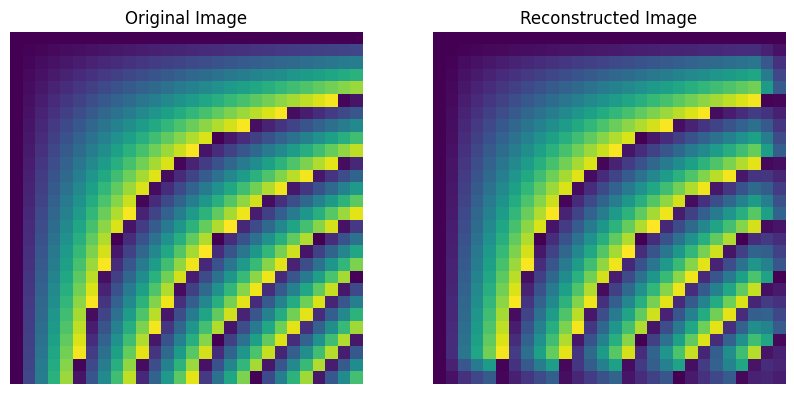

Max difference between original and reconstructed: 7.9375
Mean difference between original and reconstructed: 3.019501355229592


In [ ]:
# @title Visualize im2col col2im

# Create the test image
test_image_2d = np.ones((1, 28, 28, 1))
for i in range(28):
    for j in range(28):
        test_image_2d[0, i, j, 0] = ((i * j) % 128) / 128.0

col_matrix_test = im2col(test_image_2d, (3, 3), 1, 0)
reconstructed_image = col2im(col_matrix_test, test_image_2d.shape, (3, 3), 1, 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_image_2d[0, :, :, 0], cmap='viridis')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(reconstructed_image[0, :, :, 0], cmap='viridis')
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')

plt.show()

# Also display the difference between the two
difference = np.abs(test_image_2d - reconstructed_image)
print("Max difference between original and reconstructed:", np.max(difference))
print("Mean difference between original and reconstructed:", np.mean(difference))

In [ ]:
# @title Conv2d Layer with im2col & col2im
class Conv2D(BaseLayer):
    def __init__(self, filters, kernel_size, stride=1, padding=0, activation='relu', initializer="xavier"):
        super().__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.initializer = initializer  # New initializer parameter
        self.layer_type = "Conv2D"

        self.params = {"W": None, "b": None}

    def build(self, input_shape):
        super().build(input_shape)
        C = input_shape[-1]
        KH, KW = self.kernel_size
        if self.padding == 'same':
            self.padding = ((input_shape[1] - 1) * self.stride + KH - input_shape[1]) // 2
        self.output_shape = self._calculate_output_shape(input_shape)

        # Choose initializer
        if self.initializer == "xavier":
            self.params["W"] = np.random.randn(KH, KW, C, self.filters) * np.sqrt(2.0 / (KH * KW * C))
        elif self.initializer == "he":
            self.params["W"] = np.random.randn(KH, KW, C, self.filters) * np.sqrt(2.0 / (KH * KW * C))
        elif self.initializer == "random":
            self.params["W"] = np.random.randn(KH, KW, C, self.filters)
        else:
            raise ValueError("Invalid initializer. Choose from 'xavier', 'he', or 'random'.")

        self.params["b"] = np.zeros((1, 1, 1, self.filters))

    def _calculate_output_shape(self, input_shape):
        N, H, W, _ = input_shape
        KH, KW = self.kernel_size
        OH, OW = (H + 2 * self.padding - KH) // self.stride + 1, (W + 2 * self.padding - KW) // self.stride + 1
        return (N, OH, OW, self.filters)

    def forward(self, inputs, training=True):
        self._assert_input_shape(inputs.shape)
        self.inputs = np.pad(inputs, ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (0, 0)), 'constant')
        N, H, W, C = self.inputs.shape
        KH, KW = self.kernel_size
        _, OH, OW, _ = self.output_shape

        col_matrix = im2col(self.inputs, self.kernel_size, self.stride, 0)
        W_col = self.params["W"].reshape((KH * KW * C, self.filters))
        outputs = W_col.T @ col_matrix
        outputs = outputs + self.params["b"][0, 0, 0, :][:, np.newaxis]
        outputs = outputs.reshape((self.filters, OH, OW, N)).transpose(3, 1, 2, 0)

        if self.activation == 'relu':
            outputs = np.maximum(0, outputs)

        self.outputs = outputs
        return outputs

    def backward(self, grads, learning_rate):
        dparams = {"dW": np.zeros_like(self.params["W"]), "db": np.zeros_like(self.params["b"])}
        if self.activation == 'relu':
            grads[self.outputs <= 0] = 0

        N, H, W, C = self.inputs.shape
        KH, KW = self.kernel_size
        _, OH, OW, _ = self.output_shape

        grads_col = grads.transpose(3, 1, 2, 0).reshape((self.filters, -1))
        col_matrix = im2col(self.inputs, self.kernel_size, self.stride, 0)
        dparams["dW"] = grads_col @ col_matrix.T
        dparams["dW"] = dparams["dW"].reshape((self.filters, KH, KW, C)).transpose(1, 2, 3, 0)
        dparams["db"] = np.sum(grads, axis=(0, 1, 2)).reshape((1, 1, 1, self.filters))

        W_col = self.params["W"].reshape((self.filters, -1)).T
        dinputs_col = W_col @ grads_col
        dinputs = col2im(dinputs_col, self.inputs.shape, self.kernel_size, self.stride, self.padding)

        self.optimizer.update(self, dparams, learning_rate)

        if self.padding > 0:
            dinputs = dinputs[:, self.padding:-self.padding, self.padding:-self.padding, :]
        return dinputs

    def get_num_parameters(self):
        return np.prod(self.params["W"].shape) + np.prod(self.params["b"].shape)

    def summary(self):
        return ["Convolution2D", self.output_shape[1:], self.get_num_parameters(), "relu" if self.activation == "relu" else self.activation]

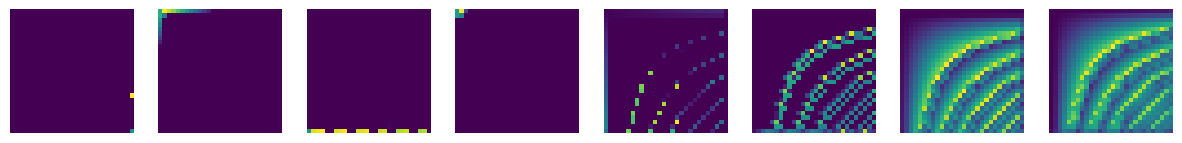

In [ ]:
# @title Visualize Conv2d
# Function to visualize feature maps
def visualize_feature_maps(feature_maps, num_columns=8):
    num_feature_maps = feature_maps.shape[-1]
    num_rows = int(np.ceil(num_feature_maps / num_columns))
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(num_feature_maps):
        axes[i].imshow(feature_maps[0, :, :, i], cmap='viridis')
        axes[i].axis('off')
    plt.show()

# Define and build the Conv2D layer
conv_layer_test = Conv2D(filters=8, kernel_size=(3, 3), stride=1, padding=1, activation='relu')
conv_layer_test.build((1, 28, 28, 1))

# Perform the forward pass and get the output feature maps
feature_maps = conv_layer_test.forward(test_image_2d)

# Visualize the output feature maps
visualize_feature_maps(feature_maps)

In [ ]:
# @title Pooling 2D vectorized
class Pooling2D(BaseLayer):
    def __init__(self, pool_size=(2, 2), stride=2, mode='max'):
        super().__init__()
        self.pool_size = pool_size
        self.stride = stride
        self.mode = mode.lower()
        self.layer_type = "Pooling2D"

    def build(self, input_shape):
        super().build(input_shape)
        batch_size, height, width, channels = input_shape
        pool_height, pool_width = self.pool_size
        self.output_shape = (
            batch_size,
            (height - pool_height) // self.stride + 1,
            (width - pool_width) // self.stride + 1,
            channels
        )

    def forward(self, inputs, training=True):
        self._assert_input_shape(inputs.shape)
        self.inputs = inputs
        outputs = self._pool(inputs)
        return outputs

    def _pool(self, inputs):
        batch_size, height, width, channels = inputs.shape
        pool_height, pool_width = self.pool_size
        outputs = np.zeros((batch_size, *self.output_shape[1:]))

        for h in range(self.output_shape[1]):
            for w in range(self.output_shape[2]):
                h_start, h_end = h * self.stride, h * self.stride + pool_height
                w_start, w_end = w * self.stride, w * self.stride + pool_width
                region = inputs[:, h_start:h_end, w_start:w_end, :]

                if self.mode == 'max':
                    outputs[:, h, w, :] = np.max(region, axis=(1, 2))
                elif self.mode == 'average':
                    outputs[:, h, w, :] = np.mean(region, axis=(1, 2))
                else:
                    raise ValueError(f"Unsupported pooling mode: {self.mode}")

        return outputs

    def backward(self, grads, learning_rate):
        return self._pool_backward(grads)

    def _pool_backward(self, grads):
        batch_size, height, width, channels = self.inputs.shape
        pool_height, pool_width = self.pool_size
        dinputs = np.zeros_like(self.inputs)

        for h in range(self.output_shape[1]):
            for w in range(self.output_shape[2]):
                h_start, h_end = h * self.stride, h * self.stride + pool_height
                w_start, w_end = w * self.stride, w * self.stride + pool_width

                if self.mode == 'max':
                    region = self.inputs[:, h_start:h_end, w_start:w_end, :]
                    max_values = np.max(region, axis=(1, 2), keepdims=True)
                    mask = (region == max_values)
                    dinputs[:, h_start:h_end, w_start:w_end, :] += mask * grads[:, h, w, :][:, None, None, :]
                elif self.mode == 'average':
                    dA = grads[:, h, w, :][:, None, None, :] / (pool_height * pool_width)
                    dinputs[:, h_start:h_end, w_start:w_end, :] += dA
                else:
                    raise ValueError(f"Unsupported pooling mode: {self.mode}")

        return dinputs

    def get_num_parameters(self):
        return 0

    def summary(self):
        return ["Pooling2D", self.output_shape[1:], 0, self.mode]

['Pooling2D', (14, 14, 1), 0, 'max']
Output Shape: (64, 14, 14, 1)


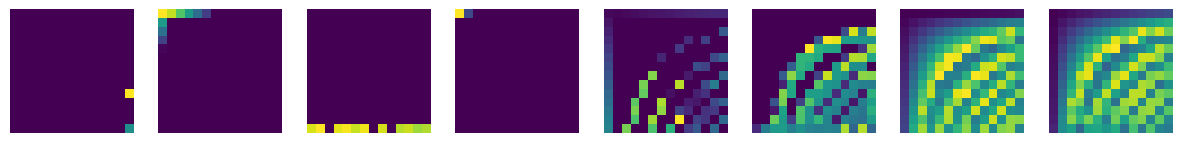

In [ ]:
# @title Visualize Pooling
# Testing the Pooling2D layer with a random input
pooling_layer = Pooling2D(pool_size=(2, 2), stride=2, mode='max')  # Instantiate the pooling layer with max pooling
pooling_layer.build((64, 28, 28, 1))  # Initialize the layer with a specific input shape
output = pooling_layer.forward(np.random.randn(64, 28, 28, 1))  # Execute the forward pass with a random input
print(pooling_layer.summary())  # Print the summary of the pooling layer
print("Output Shape:", output.shape)

# Define and build the Pooling2D layer
pooling_layer_test = Pooling2D(pool_size=(2, 2), stride=2, mode='max')
pooling_layer_test.build((1, 28, 28, 8))  # Initialize with the output shape of the previous Conv2D layer

# Perform the forward pass on the feature maps obtained from the Conv2D layer
pooled_feature_maps = pooling_layer_test.forward(feature_maps)

# Visualize the pooled feature maps
visualize_feature_maps(pooled_feature_maps)

In [ ]:
# @title Flatten & Reshape

class Flatten(BaseLayer):
    def __init__(self):
        super(Flatten, self).__init__()
        self.layer_type = "Flatten"

    def build(self, input_shape):
        super(Flatten, self).build(input_shape)
        self.input_shape = input_shape
        self.output_shape = (input_shape[0], np.prod(input_shape[1:]))

    def forward(self, inputs, training=True):
        self.input_shape = inputs.shape
        batch_size, *rest = self.input_shape
        self.outputs = inputs.reshape(batch_size, -1)
        return self.outputs

    def backward(self, grads, learning_rate):
        return grads.reshape(self.input_shape)

    def get_num_parameters(self):
        return 0

    def summary(self):
        return ["Flatten", self.output_shape[1:], 0, ""]

# Rerun the Flatten test with corrected MaxPooling2D outputs
flatten_layer = Flatten()
flatten_layer.build((64, 13, 13, 8))  # Input shape from the previous MaxPooling2D layer
print(flatten_layer.summary())

['Flatten', (1352,), 0, '']


In [ ]:
# @title Dense Layer
class Dense(BaseLayer):
    def __init__(self, units, activation="relu", initializer="xavier"):
        super(Dense, self).__init__()
        self.units = units
        self.activation = activation
        self.initializer = initializer
        self.layer_type = "Dense"

        self.params = {"W": None, "b": None}

    def build(self, input_shape):
        super(Dense, self).build(input_shape)
        input_dim = np.prod(input_shape[1:])
        self.output_shape = (input_shape[0], self.units)

        # Choose initializer
        if self.initializer == "xavier":
            # Xavier Initialization (also known as Glorot Initialization)
            self.params["W"] = np.random.randn(input_dim, self.units) * np.sqrt(2.0 / (input_dim + self.units))
        elif self.initializer == "he":
            # He Initialization
            self.params["W"] = np.random.randn(input_dim, self.units) * np.sqrt(2.0 / input_dim)
        elif self.initializer == "random":
            # Random Initialization
            self.params["W"] = np.random.randn(input_dim, self.units)
        else:
            raise ValueError("Invalid initializer. Choose from 'xavier', 'he', or 'random'.")

        self.params["b"] = np.zeros((1, self.units))

    def forward(self, inputs, training=True):
        self.inputs = inputs
        flat_inputs = inputs.reshape(inputs.shape[0], -1)
        Z = np.dot(flat_inputs, self.params["W"]) + self.params["b"]

        if self.activation == "relu":
            self.A = np.maximum(0, Z)
        elif self.activation == "sigmoid":
            self.A = 1 / (1 + np.exp(-Z))
        elif self.activation == "tanh":
            self.A = np.tanh(Z)
        elif self.activation == "softmax":
            exps = np.exp(Z - np.max(Z, axis=-1, keepdims=True))
            self.A = exps / np.sum(exps, axis=-1, keepdims=True)
        else:
            self.A = Z  # Linear activation

        return self.A

    def backward(self, dA, learning_rate):
        dparams = {"dW": np.zeros_like(self.params["W"]), "db": np.zeros_like(self.params["b"])}
        batch_size = dA.shape[0]

        if self.activation == "relu":
            dZ = np.array(dA, copy=True)
            dZ[self.A <= 0] = 0
        elif self.activation == "sigmoid":
            dZ = dA * self.A * (1 - self.A)
        elif self.activation == "tanh":
            dZ = dA * (1 - np.square(self.A))
        elif self.activation == "softmax":
            dZ = dA
        else:
            dZ = dA

        flat_inputs = self.inputs.reshape(batch_size, -1)
        dparams["dW"] = np.dot(flat_inputs.T, dZ) / batch_size
        dparams["db"] = np.sum(dZ, axis=0, keepdims=True) / batch_size

        dA_prev = np.dot(dZ, self.params["W"].T).reshape(self.inputs.shape)
        self.optimizer.update(self, dparams, learning_rate)

        return dA_prev

    def get_num_parameters(self):
        return np.prod(self.params["W"].shape) + np.prod(self.params["b"].shape)

    def summary(self):
        return ["Dense", self.output_shape[1:], self.get_num_parameters(), self.activation]

# Test the Dense layer with a sample input
dense_layer = Dense(5, activation="relu")  # Create a dense layer with 5 units and ReLU activation
dense_layer.build((None, 10, 10, 3))  # Initialize the dense layer with a sample input shape
output = dense_layer.forward(np.random.randn(3, 10, 10, 3))  # Compute the output of the dense layer
print("Output Shape:", output.shape)  # Print the shape of the output
print(dense_layer.summary())  # Print the summary of the dense layer

Output Shape: (3, 5)
['Dense', (5,), 1505, 'relu']


In [ ]:
# @title Batch Normalization
class BatchNorm(BaseLayer):
    def __init__(self, momentum=0.9, epsilon=1e-5):
        super(BatchNorm, self).__init__()
        self.momentum = momentum
        self.epsilon = epsilon
        self.running_mean = None
        self.running_variance = None
        self.params = {"gamma": None, "beta": None}
        self.layer_type = "BatchNorm"

    def build(self, input_shape):
        super(BatchNorm, self).build(input_shape)
        self.output_shape = input_shape
        channels = input_shape[-1]
        self.params["gamma"] = np.ones(channels)
        self.params["beta"] = np.zeros(channels)
        self.running_mean = np.zeros(channels)
        self.running_variance = np.zeros(channels)

    def forward(self, inputs, training=True):
        self._assert_input_shape(inputs.shape)
        self.inputs = inputs

        axis = tuple(range(inputs.ndim - 1))  # Handles different input dimensions
        mean = np.mean(inputs, axis=axis, keepdims=True)
        variance = np.var(inputs, axis=axis, keepdims=True)

        if training:
            # Compute normalized inputs during training
            self.normalized_inputs = (inputs - mean) / np.sqrt(variance + self.epsilon)

            # Update running mean and running variance
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * np.squeeze(mean)
            self.running_variance = self.momentum * self.running_variance + (1 - self.momentum) * np.squeeze(variance)
        else:
            # Use running statistics during inference
            mean = self.running_mean.reshape((1,) * (inputs.ndim - 1) + (-1,))
            variance = self.running_variance.reshape((1,) * (inputs.ndim - 1) + (-1,))
            self.normalized_inputs = (inputs - mean) / np.sqrt(variance + self.epsilon)

        # Apply gamma and beta for scaling and shifting
        out = self.params["gamma"].reshape((1,) * (inputs.ndim - 1) + (-1,)) * self.normalized_inputs + self.params["beta"].reshape((1,) * (inputs.ndim - 1) + (-1,))
        return out

    def compute_dgamma_dbeta(self, grads, axis):
        dgamma = np.sum(grads * self.normalized_inputs, axis=axis)
        dbeta = np.sum(grads, axis=axis)
        return dgamma, dbeta

    def compute_dnormalized(self, grads):
        return grads * self.params["gamma"].reshape((1,) * (grads.ndim - 1) + (-1,))

    def compute_dvariance_dmean(self, dnormalized, N, axis):
        dvariance = np.sum(dnormalized * (self.inputs - self.running_mean.reshape((1,) * (self.inputs.ndim - 1) + (-1,))) * -0.5 * np.power(self.running_variance.reshape((1,) * (self.inputs.ndim - 1) + (-1,)) + self.epsilon, -1.5), axis=axis)
        dmean = np.sum(dnormalized * -1 / np.sqrt(self.running_variance.reshape((1,) * (self.inputs.ndim - 1) + (-1,)) + self.epsilon), axis=axis) + dvariance * np.sum(-2 * (self.inputs - self.running_mean.reshape((1,) * (self.inputs.ndim - 1) + (-1,))), axis=axis) / N
        return dvariance, dmean

    def compute_dA_prev(self, dnormalized, dvariance, dmean, N):
        return dnormalized / np.sqrt(self.running_variance.reshape((1,) * (self.inputs.ndim - 1) + (-1,)) + self.epsilon) + dvariance * 2 * (self.inputs - self.running_mean.reshape((1,) * (self.inputs.ndim - 1) + (-1,))) / N + dmean / N

    def backward(self, grads, learning_rate):
        axis = tuple(range(self.inputs.ndim - 1))
        N = np.prod([self.inputs.shape[i] for i in axis])

        dparams = {}
        dparams["dgamma"], dparams["dbeta"] = self.compute_dgamma_dbeta(grads, axis)
        dnormalized = self.compute_dnormalized(grads)
        dvariance, dmean = self.compute_dvariance_dmean(dnormalized, N, axis)
        dA_prev = self.compute_dA_prev(dnormalized, dvariance, dmean, N)

        self.optimizer.update(self, dparams, learning_rate)
        return dA_prev

    def get_num_parameters(self):
        return len(self.params["gamma"]) + len(self.params["beta"])

    def summary(self):
        return ["BatchNorm", self.output_shape[1:], self.get_num_parameters(), ""]

# Testing BatchNorm Layer with corrected input dimensions
bn_layer = BatchNorm()
bn_layer.build((None, 30, 30, 8))  # Adjusted input shape to be 4D
output = bn_layer.forward(np.random.randn(5, 30, 30, 8))  # Adjusted input data to be 4D
print(bn_layer.summary())

['BatchNorm', (30, 30, 8), 16, '']


In [ ]:
# @title Layer Normalization
class LayerNorm(BaseLayer):
    def __init__(self, epsilon=1e-5):
        super(LayerNorm, self).__init__()
        self.epsilon = epsilon
        self.params = {"gamma": None, "beta": None}
        self.layer_type = "LayerNorm"

    def build(self, input_shape):
        super(LayerNorm, self).build(input_shape)
        self.output_shape = input_shape
        feature_shape = input_shape[-1]
        self.params["gamma"] = np.ones(feature_shape)
        self.params["beta"] = np.zeros(feature_shape)

    def forward(self, inputs, training=True):
        self._assert_input_shape(inputs.shape)
        self.inputs = inputs

        mean = np.mean(inputs, axis=-1, keepdims=True)
        variance = np.var(inputs, axis=-1, keepdims=True)
        self.normalized_inputs = (inputs - mean) / np.sqrt(variance + self.epsilon)

        out = self.params["gamma"] * self.normalized_inputs + self.params["beta"]
        return out

    def backward(self, grads, learning_rate):
        dparams = {}
        axis_to_sum = tuple(range(len(grads.shape) - 1))

        dparams["dgamma"] = np.sum(grads * self.normalized_inputs, axis=axis_to_sum)
        dparams["dbeta"] = np.sum(grads, axis=axis_to_sum)

        dnormalized = grads * self.params["gamma"]
        N = dnormalized.shape[-1]
        dvariance = np.sum(dnormalized * (self.inputs - np.mean(self.inputs, axis=-1, keepdims=True)) * -0.5 * np.power(np.var(self.inputs, axis=-1, keepdims=True) + self.epsilon, -1.5), axis=-1, keepdims=True)
        dmean = np.sum(dnormalized * -1 / np.sqrt(np.var(self.inputs, axis=-1, keepdims=True) + self.epsilon), axis=-1, keepdims=True) + dvariance * np.sum(-2 * (self.inputs - np.mean(self.inputs, axis=-1, keepdims=True)), axis=-1, keepdims=True) / N
        dA_prev = dnormalized / np.sqrt(np.var(self.inputs, axis=-1, keepdims=True) + self.epsilon) + dvariance * 2 * (self.inputs - np.mean(self.inputs, axis=-1, keepdims=True)) / N + dmean / N

        self.optimizer.update(self, dparams, learning_rate)
        return dA_prev

    def get_num_parameters(self):
        return len(self.params["gamma"]) + len(self.params["beta"])

    def summary(self):
        return ["LayerNorm", self.output_shape[1:], self.get_num_parameters(), ""]

# Testing LayerNorm Layer with corrected input dimensions
ln_layer = LayerNorm()
ln_layer.build((None, 30, 30, 8))  # Adjusted input shape to be 4D
output = ln_layer.forward(np.random.randn(5, 30, 30, 8))  # Adjusted input data to be 4D
print(ln_layer.summary())

['LayerNorm', (30, 30, 8), 16, '']


In [ ]:
# @title Dropout
# Dropout Layer
class Dropout(BaseLayer):
    def __init__(self, rate=0.5):
        super(Dropout, self).__init__()
        self.rate = rate
        self.layer_type = "Dropout"
        self.mask = None

    def build(self, input_shape):
        super(Dropout, self).build(input_shape)
        self.output_shape = input_shape

    def forward(self, inputs, training=True):
        self._assert_input_shape(inputs.shape)
        if training:
            self.mask = (np.random.rand(*inputs.shape) >= self.rate) / (1 - self.rate)
            return inputs * self.mask
        else:
            return inputs

    def backward(self, grads, learning_rate):
        return grads * self.mask

    def get_num_parameters(self):
        return 0

    def summary(self):
        return ["Dropout", self.output_shape[1:], 0, ""]

# Testing Dropout Layer
dropout_layer = Dropout(rate=0.5)
dropout_layer.build((None, 5))
output = dropout_layer.forward(np.random.randn(3, 5))  # Apply the Dropout layer
print(dropout_layer.summary())  # Print a summary of the layer

['Dropout', (5,), 0, '']


In [ ]:
# @title Global Average Pooling

# Implementing the Global Average Pooling 2D layer
class GlobalAvgPool2D(BaseLayer):
    def __init__(self):
        super(GlobalAvgPool2D, self).__init__()
        self.layer_type = "GlobalAvgPool2D"

    def build(self, input_shape):
        super().build(input_shape)
        self.output_shape = (input_shape[0], input_shape[-1])

    def forward(self, inputs, training=True):
        self.inputs = inputs
        return np.mean(inputs, axis=(1, 2))

    def backward(self, grads, learning_rate):
        N, H, W, C = self.inputs.shape
        grads_expanded = np.ones((N, H, W, C)) * grads[:, np.newaxis, np.newaxis, :] / (H * W)
        return grads_expanded

    def get_num_parameters(self):
        return 0  # No trainable parameters

    def summary(self):
        return ["GlobalAvgPool2D", self.output_shape[1:], self.get_num_parameters(), None]

In [ ]:
# @title Skip Connection

class SkipConnection(BaseLayer):
    def __init__(self, skip_from, operation='add'):
        super(SkipConnection, self).__init__()
        self.skip_from = skip_from
        self.operation = operation
        self.layer_type = "SkipConnection"
        self.alpha = 1.0  # Initialize alpha to 1.0 for fully using the main path

    def build(self, input_shape):
        self.output_shape = input_shape
        self.skip_input_shape = None  # Will be set during the forward pass
        self.W = None  # 1x1 Convolution weights
        self.resized_skip_input = None  # Store the resized skip_input

    def forward(self, inputs, skip_input, training=True):
        self.inputs = inputs  # Store the inputs for the backward pass
        if inputs.shape != skip_input.shape:
            self.skip_input_shape = skip_input.shape
            target_channels = inputs.shape[-1]
            if self.W is None:
                self.W = np.random.randn(1, 1, skip_input.shape[-1], target_channels)
            col_skip_input = im2col(skip_input, (1, 1), 1, 0)

            # Perform the 1x1 convolution
            temp_W = self.W.reshape(-1, target_channels)
            temp_output = temp_W.dot(col_skip_input)

            # Reshape the output back to the shape of inputs
            skip_input_reshaped = col2im(temp_output, inputs.shape, (1, 1), 1, 0)
            skip_input = skip_input_reshaped

        self.resized_skip_input = skip_input  # Store the resized skip_input

        if self.operation == 'add':
            return self.alpha * inputs + (1 - self.alpha) * skip_input
        elif self.operation == 'multiply':
            return (self.alpha * inputs) * ((1 - self.alpha) * skip_input + 1)
        elif self.operation == 'concat':
            return np.concatenate([self.alpha * inputs, (1 - self.alpha) * skip_input], axis=-1)
        else:
            raise ValueError(f"Unsupported operation: {self.operation}")

    def backward(self, grads, learning_rate):
        d_alpha = np.sum(grads * (self.inputs - self.resized_skip_input))

        self.alpha -= learning_rate * d_alpha  # Update alpha

        if self.skip_input_shape is not None:
            col_grads = im2col(grads, (1, 1), 1, 0)
            dW = col_grads.dot(grads.reshape(-1, self.skip_input_shape[-1])).reshape(self.W.shape)
            self.W -= learning_rate * dW  # Update 1x1 Conv weights

        return grads  # gradients pass through without modification

    def summary(self):
        return ["SkipConnection", self.output_shape[1:], 1, f"Skip from {self.skip_from}"]


In [ ]:
# @title #Model
# Model class for building and training neural networks
class Model:
    def __init__(self):
        self.layers = []
        self.compiled = False
        self.optimizer = None

    def add(self, layer):
        self.layers.append(layer)

    def compile(self, input_shape, optimizer, initializer='xavier'):
        if not optimizer:
            raise Exception("Optimizer must be set before compiling.")

        self.optimizer = optimizer  # Store the optimizer at the model level
        self.initializer = initializer  # Store the initializer at the model level
        current_shape = input_shape
        for layer in self.layers:
            if hasattr(layer, 'initializer'):  # Check if the layer has an initializer attribute
                layer.initializer = self.initializer  # Set the initializer for the layer
            layer.build(current_shape)
            layer.optimizer = self.optimizer  # Initialize the optimizer for each layer
            layer.optimizer.init_params(layer)  # Initialize optimizer parameters for the layer
            current_shape = layer.output_shape
        self.compiled = True

    def forward(self, inputs, training=True, return_layer=None):
        # Initialize an empty list to store layer outputs for skip connections
        layer_outputs = []

        current_output = inputs
        for i, layer in enumerate(self.layers):
            if layer.layer_type == "SkipConnection":
                # Retrieve the output from the layer specified in skip_from
                skip_input = layer_outputs[layer.skip_from]
                current_output = layer.forward(current_output, skip_input, training=training)
            else:
                current_output = layer.forward(current_output, training=training)

            layer_outputs.append(current_output)

            if return_layer is not None and i == return_layer:
                return current_output

        return current_output

    def backward(self, grads, learning_rate):
        current_grad = grads
        for layer in reversed(self.layers):
            if layer.layer_type == "SkipConnection":
                continue  # SkipConnection layers don't change gradients
            current_grad = layer.backward(current_grad, learning_rate)

    def summary(self):
        if not self.compiled:
            raise Exception("Model needs to be compiled before summary.")

        total_params = sum(layer.get_num_parameters() for layer in self.layers)
        print("Layer #   OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)   ACTIVATION")
        print("============================================================================")

        for i, layer in enumerate(self.layers):
            operation, data_dims, weights_n, activation = layer.summary()
            if operation is None:
                continue
            weights_perc = (weights_n / total_params * 100) if total_params > 0 else 0
            data_dims_str = 'x'.join(str(dim) for dim in data_dims)
            activation_str = activation.upper() if activation else ""
            print(f"{i:<8} {operation:<20} {data_dims_str:>15} {weights_n:>12} {weights_perc:>10.1f}% {activation_str}")

        print("============================================================================")
        print(f"Total Parameters: {total_params:,}")


    def train_on_batch(self, inputs, targets, loss_fn, learning_rate, l2_lambda=0.01):
        predictions = self.forward(inputs, training=True)
        loss, grads = loss_fn(predictions, targets)

        # Use l2_regularization method from BaseLayer class
        l2_loss = sum(layer.l2_regularization(l2_lambda) for layer in self.layers)

        # Average regularization loss over the batch
        loss += l2_loss / targets.shape[0]

        self.backward(grads, learning_rate)  # Pass the actual learning_rate
        return loss

    def predict(self, inputs):
        # Make predictions using the trained model
        return self.forward(inputs, training=False)

    def fit(self, X_train, y_train, X_val, y_val, batch_size, epochs, loss_fn,
            l2_lambda=0.01, lr_scheduler=None, checkpoint_path=None, callbacks=[], augmentor=None):

        if not self.compiled:
            raise Exception("Model needs to be compiled before training.")

        # Extract the initial learning rate from the lr_scheduler or use a default value
        learning_rate = lr_scheduler.initial_lr if lr_scheduler else 0.01

        history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
        n_batches = int(np.ceil(X_train.shape[0] / batch_size))
        best_val_loss = float('inf')

        for epoch in range(epochs):
            for callback in callbacks:
                callback.on_epoch_begin(epoch)

            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            epoch_train_losses = []

            print(f"\n Epoch {epoch+1}/{epochs}")
            for i in range(n_batches):
                X_batch = X_train_shuffled[i*batch_size:(i+1)*batch_size]
                y_batch = y_train_shuffled[i*batch_size:(i+1)*batch_size]

                if augmentor:
                    X_batch = augmentor.augment(X_batch)

                batch_train_loss = self.train_on_batch(X_batch, y_batch, loss_fn, learning_rate, l2_lambda)
                epoch_train_losses.append(batch_train_loss)

                progress = (i+1) / n_batches
                filled_elements = int(progress * 40)
                bar = '=' * filled_elements + '>' + '.' * (39 - filled_elements)
                print(f"\r[{bar}] Batch {i+1}/{n_batches} - Loss: {batch_train_loss:.4f}", end="")

            train_predictions = np.concatenate(
                [self.predict(X_train[i*batch_size:(i+1)*batch_size])
                for i in range(int(np.ceil(X_train.shape[0] / batch_size)))], axis=0)

            train_predicted_labels = np.argmax(train_predictions, axis=1)
            train_true_labels = np.argmax(y_train, axis=1)
            train_accuracy = np.mean(train_predicted_labels == train_true_labels)
            train_loss = np.mean(epoch_train_losses)

            val_predictions = np.concatenate(
                [self.predict(X_val[i*batch_size:(i+1)*batch_size])
                for i in range(int(np.ceil(X_val.shape[0] / batch_size)))], axis=0)

            val_loss, _ = loss_fn(val_predictions, y_val)
            val_predicted_labels = np.argmax(val_predictions, axis=1)
            val_true_labels = np.argmax(y_val, axis=1)
            val_accuracy = np.mean(val_predicted_labels == val_true_labels)

            print(f" - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

            if checkpoint_path and val_loss < best_val_loss:
                self.save(checkpoint_path)
                best_val_loss = val_loss
                print(f"Checkpoint saved to {checkpoint_path}")

            if lr_scheduler:
                learning_rate = lr_scheduler(epoch, val_loss)

            for callback in callbacks:
                callback.on_epoch_end(epoch, logs={
                    'train_loss': train_loss,
                    'train_accuracy': train_accuracy,
                    'val_loss': val_loss,
                    'val_accuracy': val_accuracy
                })

            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_accuracy)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)

        return history

    def save(self, filename):
        model_state = {'layers': [], 'compiled': self.compiled}
        for layer in self.layers:
            layer_type = type(layer).__name__
            init_args = {}
            if layer_type == 'Dense':
                init_args = {
                    'units': layer.units,
                    'activation': layer.activation,
                    'initializer': layer.initializer
                }
            # Add additional conditions for other layer types here
            layer_state = {
                'type': layer_type,
                'init_args': init_args,
                'state': layer.__dict__
            }
            model_state['layers'].append(layer_state)
        with open(filename, 'wb') as file:
            pickle.dump(model_state, file)
        print(f"Model saved to {filename}")


    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as file:
            model_state = pickle.load(file)
        new_model = cls()
        new_model.compiled = model_state.get('compiled', False)
        for layer_state in model_state['layers']:
            layer_type = layer_state['type']
            init_args = layer_state['init_args']
            layer_class = globals()[layer_type]
            layer_instance = layer_class(**init_args)
            layer_instance.__dict__.update(layer_state['state'])
            new_model.layers.append(layer_instance)
        print(f"Model loaded from {filename}")
        return new_model

In [ ]:
# @title Loss Functions

# Helper function for MSE loss and its gradient
def mse_loss(predictions, targets):
    m = targets.shape[0]
    loss = np.mean((predictions - targets) ** 2)
    grads = (2 / m) * (predictions - targets)
    return loss, grads

def categorical_crossentropy(predictions, targets):
    m = targets.shape[0]
    clipped_predictions = np.clip(predictions, 1e-7, 1 - 1e-7)  # For numerical stability
    loss = -np.sum(targets * np.log(clipped_predictions)) / m
    grads = predictions - targets  # This is the gradient of softmax with cross-entropy loss
    return loss, grads

def huber_loss(predictions, targets):
    delta=1.0
    residual = predictions - targets
    abs_residual = np.abs(residual)
    mask = abs_residual <= delta
    loss = np.where(mask, 0.5 * (residual ** 2), delta * (abs_residual - 0.5 * delta))
    loss = np.mean(loss)
    grads = np.where(mask, residual, delta * np.sign(residual))
    return loss, grads

def binary_crossentropy(predictions, targets):
    m = targets.shape[0]
    clipped_predictions = np.clip(predictions, 1e-7, 1 - 1e-7)
    loss = -np.sum(targets * np.log(clipped_predictions) + (1 - targets) * np.log(1 - clipped_predictions)) / m
    grads = (predictions - targets) / (predictions * (1 - predictions) + 1e-7)
    return loss, grads

def focal_loss(predictions, targets):
    gamma=2
    m = targets.shape[0]
    clipped_predictions = np.clip(predictions, 1e-7, 1 - 1e-7)
    loss = -np.sum(targets * np.power(1 - clipped_predictions, gamma) * np.log(clipped_predictions)) / m
    grads = - (targets - clipped_predictions) * np.power(1 - clipped_predictions, gamma - 1)
    return loss, grads

In [ ]:
# @title Learning Rate Scheduler
class LRScheduler:
    def __init__(self, initial_lr, lr_decay_factor=0.1, step_size=10, min_lr=1e-6,
                 patience=1, cooldown=0, patient=True):
        self.initial_lr = initial_lr
        self.lr = initial_lr
        self.lr_decay_factor = lr_decay_factor
        self.step_size = step_size
        self.min_lr = min_lr
        self.patience = patience
        self.cooldown = cooldown
        self.wait = 0
        self.best_loss = float('inf')
        self.cooldown_counter = 0
        self.patient = patient

    def update_lr(self):
        new_lr = max(self.lr * self.lr_decay_factor, self.min_lr)
        print(f"Learning rate scheduler: new_lr = {new_lr}, current_lr = {self.lr}")  # Debug print
        if new_lr < self.lr:
            self.lr = new_lr
            self.cooldown_counter = self.cooldown
            self.wait = 0

    def on_epoch_end(self, epoch, val_loss):
        if self.cooldown_counter > 0:
            self.cooldown_counter -= 1
            self.wait = 0

        if self.patient:
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.wait = 0
            else:
                self.wait += 1

            if self.wait >= self.patience:
                self.update_lr()
        else:
            if (epoch + 1) % self.step_size == 0:
                self.update_lr()

    def __call__(self, epoch, val_loss=None):
        if val_loss is not None:
            self.on_epoch_end(epoch, val_loss)
        return self.lr

In [104]:
# @title Data Augmentor
class ImageDataAugmentor:
    def __init__(self, augmentations=None, random_seed=None):
        self.augmentations = augmentations or []
        self.random_state = np.random.RandomState(random_seed)

    def antialiasing(self, src_x, src_y, channel):
        h, w = channel.shape[:2]
        is_gray = len(channel.shape) == 2 or channel.shape[-1] == 1

        if is_gray:
            channel = np.squeeze(channel)  # Remove singleton dimensions if any

        x_floor, y_floor = np.floor(src_x).astype(int), np.floor(src_y).astype(int)
        x_ceil, y_ceil = np.ceil(src_x).astype(int), np.ceil(src_y).astype(int)
        x_floor = np.clip(x_floor, 0, w-1)
        x_ceil = np.clip(x_ceil, 0, w-1)
        y_floor = np.clip(y_floor, 0, h-1)
        y_ceil = np.clip(y_ceil, 0, h-1)

        lt = channel[y_floor, x_floor]
        rt = channel[y_floor, x_ceil]
        lb = channel[y_ceil, x_floor]
        rb = channel[y_ceil, x_ceil]

        dx, dy = src_x - x_floor, src_y - y_floor
        result = lt * (1-dx) * (1-dy) + rt * dx * (1-dy) + lb * (1-dx) * dy + rb * dx * dy

        if is_gray:
            result = np.expand_dims(result, axis=-1)  # Explicitly keep the last dimension

        return np.squeeze(result)

    def resize_image(self, image, target_shape):
        h, w = image.shape[:2]
        target_h, target_w = target_shape[:2]
        scale_x = w / target_w
        scale_y = h / target_h
        is_gray = len(image.shape) == 2
        num_channels = 1 if is_gray else image.shape[2]
        new_image_shape = (target_h, target_w, num_channels) if not is_gray else (target_h, target_w)
        new_image = np.zeros(new_image_shape, dtype=np.float32)
        y_indices, x_indices = np.indices((target_h, target_w))
        src_x = x_indices * scale_x
        src_y = y_indices * scale_y

        if is_gray:
            new_image = self.antialiasing(src_x, src_y, image)
            new_image = new_image[:, :, np.newaxis]  # Adding channel dimension
        else:
            for c in range(num_channels):
                new_image[..., c] = self.antialiasing(src_x, src_y, image[..., c])
        return new_image

    def rotate(self, image, angle_deg):
        angle_rad = np.radians(angle_deg)
        cos, sin = np.cos(angle_rad), np.sin(angle_rad)
        h, w = image.shape[:2]
        is_gray = len(image.shape) == 2 or image.shape[-1] == 1  # Added check for image.shape[-1] == 1
        num_channels = 1 if is_gray else image.shape[2]
        center_y, center_x = np.array([h, w]) // 2

        y_indices, x_indices = np.indices((h, w))
        coords = np.stack([x_indices - center_x, y_indices - center_y], axis=-1)

        new_coords = coords @ np.array([[cos, -sin], [sin, cos]])

        src_x = new_coords[..., 0] + center_x
        src_y = new_coords[..., 1] + center_y

        rotated_image = np.zeros((h, w, num_channels), dtype=np.float32)
        if is_gray:
            rotated_image[..., 0] = self.antialiasing(src_x, src_y, np.squeeze(image))  # Use np.squeeze to remove singleton dimensions if any
            rotated_image = np.expand_dims(rotated_image[..., 0], axis=-1)  # Explicitly keep the last dimension
        else:
            for c in range(num_channels):
                rotated_image[..., c] = self.antialiasing(src_x, src_y, image[..., c])

        return rotated_image  # Removed np.squeeze, as it's now handled explicitly

    def translate(self, image, dx, dy):
        h, w = image.shape[:2]
        num_channels = image.shape[2] if len(image.shape) > 2 else 1
        new_image_shape = (h, w, num_channels) if num_channels > 1 else (h, w)
        translated_image = np.zeros(new_image_shape, dtype=np.float32)

        y_indices, x_indices = np.indices((h, w))
        src_x = x_indices - dx
        src_y = y_indices - dy

        if num_channels == 1:
            translated_image = self.antialiasing(src_x, src_y, image)
        else:
            for c in range(num_channels):
                translated_image[..., c] = self.antialiasing(src_x, src_y, image[..., c])
        return translated_image

    def random_crop(self, image, crop_size):
        h, w = image.shape[:2]
        crop_h, crop_w = crop_size
        top = np.random.randint(0, h - crop_h + 1)
        left = np.random.randint(0, w - crop_w + 1)
        cropped_image = image[top:top + crop_h, left:left + crop_w]
        return cropped_image

    def flip(self, image, horizontal=False, vertical=False):
        if horizontal:
            image = np.fliplr(image)
        if vertical:
            image = np.flipud(image)
        return image

    def adjust_brightness(self, image, factor):
        return np.clip(image * factor, 0, 1)

    def add_gaussian_noise(self, image, mean=0, std=0.1):
        noise = np.random.normal(mean, std, image.shape)
        noisy_image = np.clip(image + noise, 0, 1)
        return noisy_image

    def add_salt_pepper_noise(self, image, salt_prob=0.05, pepper_prob=0.05):
        noise = np.random.choice([0, 1, 2], size=image.shape[:2], p=[salt_prob, pepper_prob, 1-salt_prob-pepper_prob])
        noisy_image = np.copy(image)
        noisy_image[noise == 0] = 0
        noisy_image[noise == 1] = 1
        return noisy_image

    def add_poisson_noise(self, image, lam=0.1):  # Reduced lambda
        noise = np.random.poisson(lam, image.shape) * 0.01  # Scale down the noise
        noisy_image = np.clip(image + noise, 0, 1)
        return noisy_image

    def jitter(self, image, sigma=1.0):
        h, w = image.shape[:2]
        num_channels = image.shape[2] if len(image.shape) > 2 else 1
        jittered_image = np.zeros_like(image, dtype=np.float32)
        x_offsets = np.random.normal(0, sigma, (h, w))
        y_offsets = np.random.normal(0, sigma, (h, w))
        y_indices, x_indices = np.indices((h, w))
        src_x = x_indices + x_offsets
        src_y = y_indices + y_offsets
        if num_channels == 1:
            jittered_image = self.antialiasing(src_x, src_y, image)
        else:
            for c in range(num_channels):
                jittered_image[..., c] = self.antialiasing(src_x, src_y, image[..., c])
        return jittered_image

    def channel_shuffle(self, image):
        if len(image.shape) < 3 or image.shape[2] < 2:
            # Cannot shuffle channels for grayscale image or image with only one channel
            return image

        shuffled_image = np.copy(image)
        channel_indices = np.arange(image.shape[2])
        self.random_state.shuffle(channel_indices)
        shuffled_image = image[..., channel_indices]

        return shuffled_image

    def augment(self, images, target_shape=(28,28)):
        augmented_images = []
        for image in images:
            for aug_fn, prob in self.augmentations:
                if self.random_state.rand() < prob:
                    image = aug_fn(self, image)
            image = self.resize_image(image, target_shape)
            augmented_images.append(image)
        return np.stack(augmented_images, axis=0)

In [105]:
# @title Fashion Mnist
from keras.datasets import fashion_mnist

def load_and_preprocess_data():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    # Expand dimensions and normalize
    X_train = np.expand_dims(X_train, axis=-1) / 255.0
    X_test = np.expand_dims(X_test, axis=-1) / 255.0

    # One-hot encode labels
    y_train_oh = np.eye(10)[y_train]
    y_test_oh = np.eye(10)[y_test]

    return X_train, y_train_oh, X_test, y_test_oh

X_train, y_train, X_test, y_test = load_and_preprocess_data()

# Split the data into training and validation sets
train_size = int(0.9 * X_train.shape[0])  # 90% for training

X_val = X_train[train_size:]
y_val = y_train[train_size:]

X_train = X_train[:train_size]
y_train = y_train[:train_size]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (54000, 28, 28, 1)
y_train shape: (54000, 10)
X_val shape: (6000, 28, 28, 1)
y_val shape: (6000, 10)


In [ ]:
# @title Cifar10
from keras.datasets import cifar10

def load_and_preprocess_data():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    # Normalize pixel values to [0, 1]
    X_train, X_test = X_train / 255.0, X_test / 255.0

    # Flatten the label arrays
    y_train, y_test = y_train.flatten(), y_test.flatten()

    # One-hot encode labels
    y_train_oh = np.eye(10)[y_train]
    y_test_oh = np.eye(10)[y_test]

    return X_train, y_train_oh, X_test, y_test_oh

X_train, y_train, X_test, y_test = load_and_preprocess_data()

# Split the data into training and validation sets
train_size = int(0.9 * X_train.shape[0])  # 90% for training

X_val = X_train[train_size:]
y_val = y_train[train_size:]

X_train = X_train[:train_size]
y_train = y_train[:train_size]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


170498071/170498071 [==============================] - 11s 0us/step
X_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 10)
X_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 10)


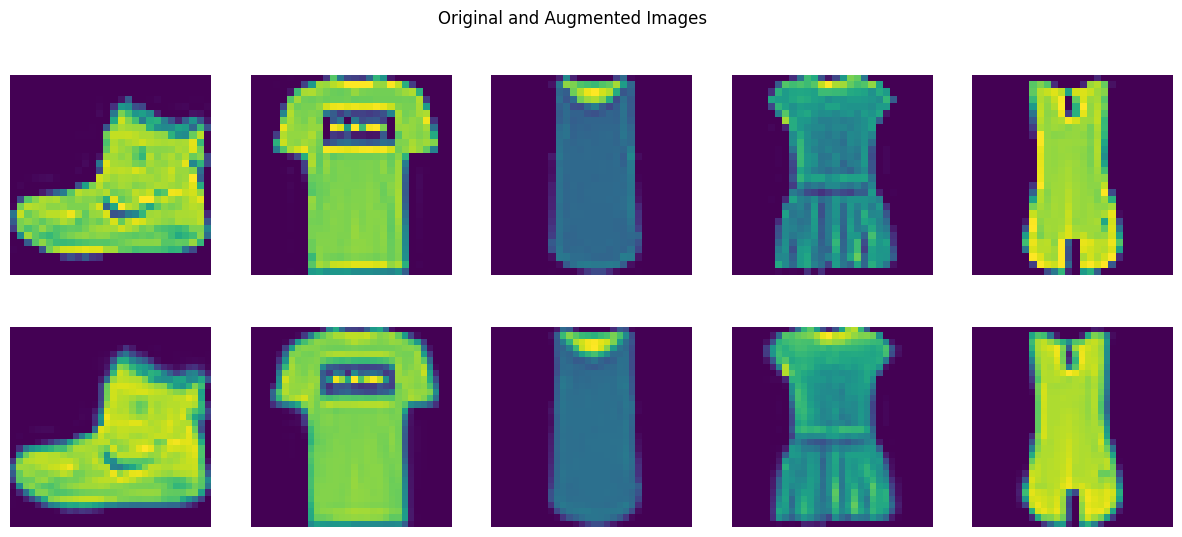

In [110]:
augmentations = [
#    (lambda self, img: self.rotate(img, np.random.uniform(-25, 25)), 0.15),
#    (lambda self, img: self.translate(img, np.random.uniform(-10, 10), np.random.uniform(-10, 10)), 0.15),
#    (lambda self, img: self.random_crop(img, (25, 25)), 0.15),  # Crop size is 20x20
#    (lambda self, img: self.adjust_brightness(img, np.random.uniform(0.5, 1.5)), 0.2),  # Factor between 0.5 and 1.5
#    (lambda self, img: self.flip(img, horizontal=np.random.choice([True, False]), vertical=np.random.choice([False, False])), 0.2),
    (lambda self, img: self.add_gaussian_noise(img, std=np.random.uniform(0.01, 0.2)), 0.15),
    (lambda self, img: self.add_salt_pepper_noise(img, salt_prob=np.random.uniform(0.01, 0.1), pepper_prob=np.random.uniform(0.01, 0.1)), 0.1),
#    (lambda self, img: self.add_poisson_noise(img, lam=np.random.uniform(1, 20)), 0.15),
    (lambda self, img: self.jitter(img, sigma=np.random.uniform(0.1, 0.5)), 0.15),
#    (lambda self, img: self.channel_shuffle(img), 0.1),
]

augmentor = ImageDataAugmentor(augmentations=augmentations)

sample_images = X_train[:5]
augmented_images = augmentor.augment(sample_images,target_shape=(32,32))

# Check if images are grayscale or colored
is_gray = sample_images.shape[-1] == 1  # True if grayscale, False otherwise
color_map = 'viridis' if is_gray else None

# Display the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Original and Augmented Images")
for i in range(5):
    axes[0, i].imshow(np.squeeze(sample_images[i]), cmap=color_map)  # Squeeze to remove single-dimensional entries from the shape
    axes[0, i].axis('off')
    axes[1, i].imshow(np.squeeze(augmented_images[i]), cmap=color_map)
    axes[1, i].axis('off')
plt.show()

In [111]:
# Create the custom model object
model = Model()

# Convolutional block 1
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='same'))  # Layer 0
model.add(LayerNorm())  # Layer 1
model.add(Pooling2D(pool_size=(2, 2), stride=2, mode='max'))  # Layer 2


model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))  # Layer 0
model.add(LayerNorm())  # Layer 1
model.add(Pooling2D(pool_size=(2, 2), stride=2, mode='max'))  # Layer 2

# Global Average Pooling
model.add(Flatten())  # Layer 17

# Fully connected layers
model.add(Dense(128, activation='relu'))  # Layer 18
model.add(Dropout(0.1))  # Layer 19
model.add(LayerNorm())  # Layer 20
model.add(Dense(64, activation='relu'))  # Layer 21
model.add(LayerNorm())  # Layer 22


# Output Layer - Assuming a 10-class classification problem
model.add(Dense(10, activation='softmax'))  # Layer 23

# Compile the model with the input shape
input_shape = (None, 28, 28, 1)
optimizer = Adam(use_agc=True)
model.compile(input_shape=input_shape, optimizer=optimizer, initializer='he')

# Learning Rate Scheduler
lr_scheduler = LRScheduler(
    initial_lr=0.001,
    lr_decay_factor=0.05,
    step_size=2,
    min_lr=1e-6,
    patience=3,
    cooldown=2,
    patient=True
)

# Print model summary
model.summary()


Layer #   OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)   ACTIVATION
0        Convolution2D               28x28x32          832        0.2% RELU
1        LayerNorm                   28x28x32           64        0.0% 
2        Pooling2D                   14x14x32            0        0.0% MAX
3        Convolution2D               14x14x64        18496        4.3% RELU
4        LayerNorm                   14x14x64          128        0.0% 
5        Pooling2D                     7x7x64            0        0.0% MAX
6        Flatten                         3136            0        0.0% 
7        Dense                            128       401536       93.3% RELU
8        Dropout                          128            0        0.0% 
9        LayerNorm                        128          256        0.1% 
10       Dense                             64         8256        1.9% RELU
11       LayerNorm                         64          128        0.0% 
12       Dense               

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train, X_val, y_val, batch_size=128, epochs=50, loss_fn=categorical_crossentropy,
    l2_lambda=0.01, lr_scheduler=lr_scheduler, checkpoint_path='best_model.pkl', augmentor=augmentor
)


 Epoch 1/50
[========================================>] Batch 422/422 - Loss: 0.3867 - Train Loss: 0.4987 - Train Accuracy: 0.8946 - Val Loss: 0.3017 - Val Accuracy: 0.8857
Model saved to best_model.pkl
Checkpoint saved to best_model.pkl

 Epoch 2/50
[========================================>] Batch 422/422 - Loss: 0.4124 - Train Loss: 0.3533 - Train Accuracy: 0.9069 - Val Loss: 0.2783 - Val Accuracy: 0.8965
Model saved to best_model.pkl
Checkpoint saved to best_model.pkl

 Epoch 3/50
[========================================>] Batch 422/422 - Loss: 0.3525 - Train Loss: 0.3245 - Train Accuracy: 0.9128 - Val Loss: 0.2784 - Val Accuracy: 0.8968

 Epoch 4/50
[========================================>] Batch 422/422 - Loss: 0.2826 - Train Loss: 0.3067 - Train Accuracy: 0.9201 - Val Loss: 0.2569 - Val Accuracy: 0.9020
Model saved to best_model.pkl
Checkpoint saved to best_model.pkl

 Epoch 5/50
[========================================>] Batch 422/422 - Loss: 0.2911 - Train Loss: 0.2949 - 

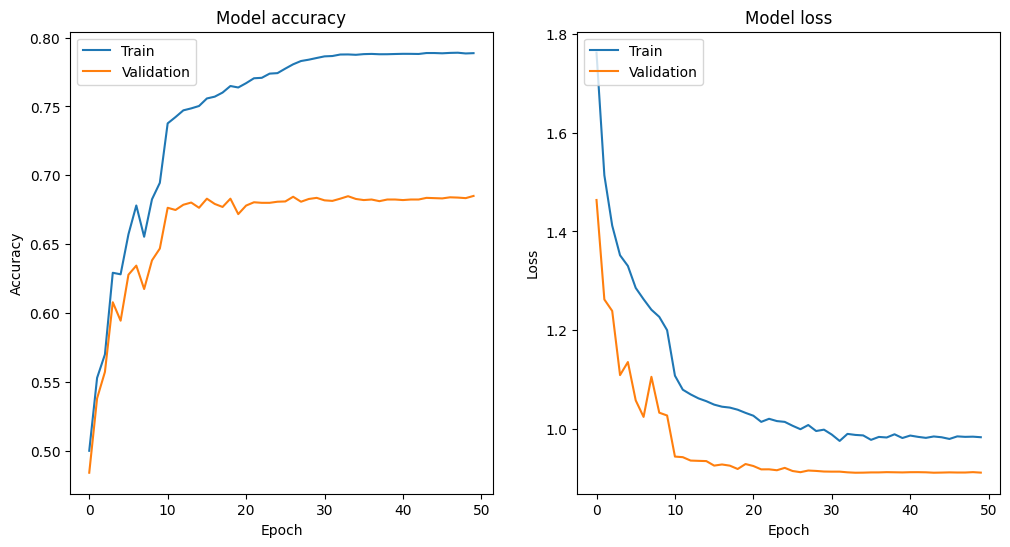

In [93]:
# @title Model History
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

In [94]:
#model.load('best_model.pkl')

test_predictions = model.predict(X_test)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(y_test, axis=1)
test_accuracy = np.mean(test_predicted_labels == test_true_labels)
print(f"Model Test accuracy: {test_accuracy}")

Model Test accuracy: 0.6763


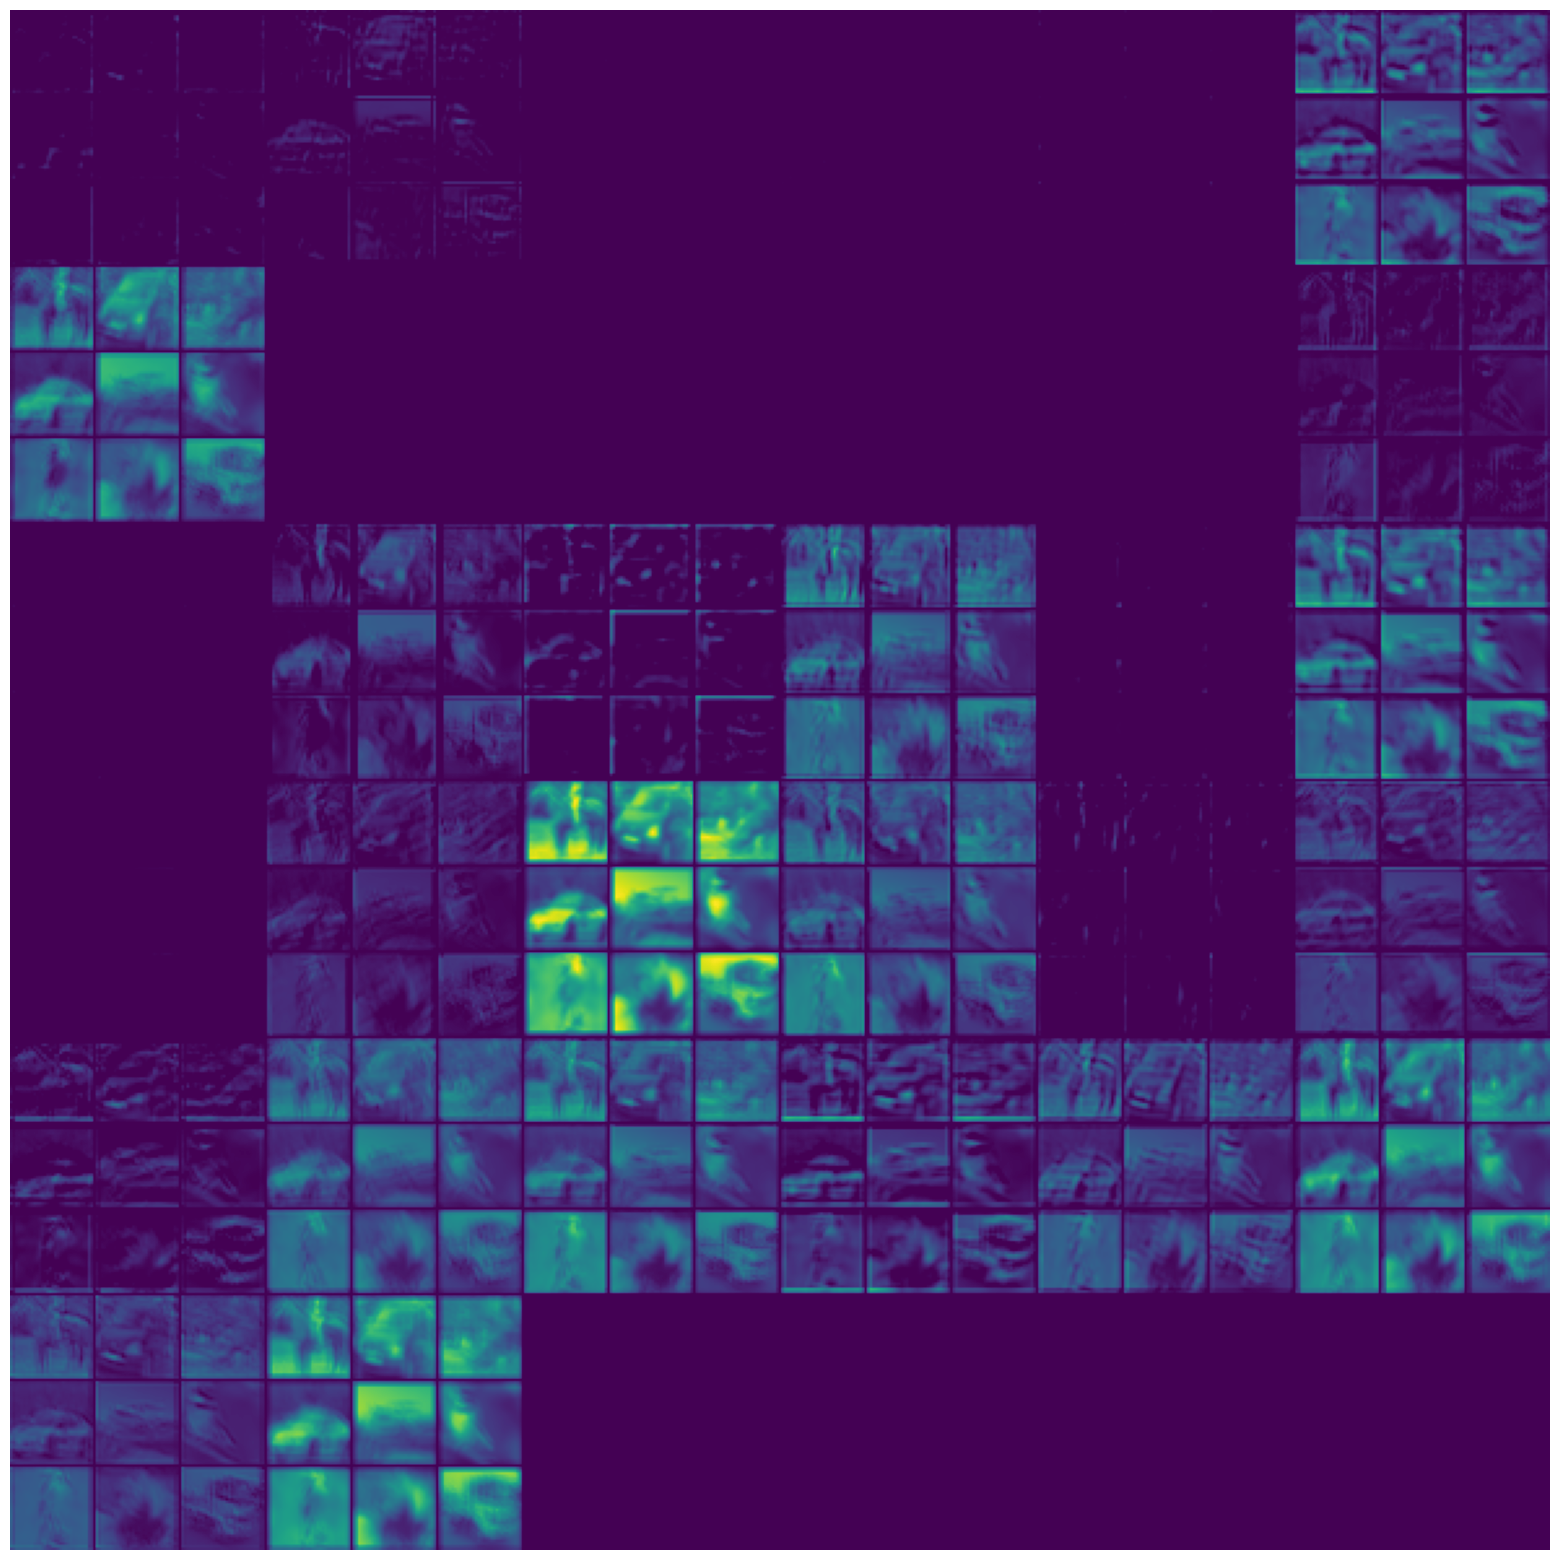

In [103]:
def get_layer_output(model, layer_index, X_sample):
    layer_outputs = []  # Store outputs of each layer
    current_output = X_sample
    for i, layer in enumerate(model.layers[:layer_index + 1]):
        if layer.layer_type == "SkipConnection":
            # Retrieve the output from the layer specified in skip_from
            skip_input = layer_outputs[layer.skip_from]
            current_output = layer.forward(current_output, skip_input, training=False)
        else:
            current_output = layer.forward(current_output, training=False)

        layer_outputs.append(current_output)  # Store the output for potential skip connections later

    return current_output

def visualize_grid(Xs, ubound=255.0, padding=1):
    N, H, W, C = Xs.shape
    grid_size = int(N ** 0.5)
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))

    for idx, img in enumerate(Xs):
        y, x = divmod(idx, grid_size)
        y0, y1, x0, x1 = y * (H + padding), (y + 1) * H + y * padding, x * (W + padding), (x + 1) * W + x * padding
        img_min, img_max = img.min(), img.max()
        grid[y0:y1, x0:x1] = ubound * (img - img_min) / (img_max - img_min)

    return grid

def visualize_feature_maps_single_image(feature_maps, padding=1):
    H, W, C = feature_maps.shape
    grid_size = int(np.ceil(C ** 0.5))
    H_new, W_new = H * grid_size + padding * (grid_size - 1), W * grid_size + padding * (grid_size - 1)
    output_image = np.zeros((H_new, W_new))
    for idx in range(C):
        y, x = divmod(idx, grid_size)
        y0, y1, x0, x1 = y * (H + padding), (y + 1) * H + y * padding, x * (W + padding), (x + 1) * W + x * padding
        output_image[y0:y1, x0:x1] = feature_maps[:, :, idx]

    plt.figure(figsize = (20,20))
    plt.imshow(output_image, cmap='viridis')
    plt.axis('off')
    plt.show()

sample_image = X_val[0:9]
layer_index = 0

layer_output = get_layer_output(model, layer_index, sample_image)
visualized_output = visualize_grid(layer_output)
visualize_feature_maps_single_image(visualized_output)